# Deep Neural Network for Binary Classification

Goal: just to show how it is done with Keras

In [1]:
from time import time
import numpy as np
import pandas as pd
import sklearn.datasets as datasets
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = datasets.load_breast_cancer()

# IMPORTANT: switch target labels as malignant should be 1

X = pd.DataFrame(data['data'], columns=data['feature_names'])
y = 1-pd.Series(data['target'], name='target') # which labels

labels = data['target_names'][[1,0]]
display(X.head())

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


# Split training and test data

In [3]:
from sklearn.model_selection import train_test_split

random_seed = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=random_seed)

print("train: ", X_train.shape, ', test:', X_test.shape)

train:  (398, 30) , test: (171, 30)


# Feature Scaling

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Building (Deep) Neural Network

In [5]:
from keras.layers import Dense, Input, Dropout
from keras.models import Model

input_dim = X_train.shape[1]

input = Input(shape=(input_dim,))
tensor = Dense(units=100, activation='relu')(input)
tensor = Dropout(rate=0.3)(tensor)
tensor = Dense(units=100, activation='relu')(tensor)
tensor = Dropout(rate=0.3)(tensor)
tensor = Dense(units=100, activation='relu')(tensor)
tensor = Dropout(rate=0.3)(tensor)
tensor = Dense(units=1, activation='sigmoid')(tensor)

model = Model(input, tensor)
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               3100      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
__________

In [6]:
model.compile(optimizer='sgd', loss='binary_crossentropy', )

In [7]:
start = time()
model.fit(X_train_scaled, y_train, epochs=1000, batch_size=256, shuffle=True, verbose=0)
print('-> took %.1f seconds' % (time() - start))

-> took 12.1 seconds


In [8]:
y_hat = model.predict(X_test_scaled)

In [9]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc, classification_report

def plot_roc(y_true, y_hat, ax):
    fpr, tpr, thres = roc_curve(y_true, y_hat)
    
    ax.plot(fpr, tpr, label='(AUC = %0.3f)' % auc(fpr, tpr))
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    ax.set_title('ROC Curve')
    ax.legend()

def plot_pr_curve(y_true, y_hat, ax):
    prec, recl, thres = precision_recall_curve(y_true, y_hat)
    
    ax.plot(recl, prec, label='(AUC = %0.3f)' % auc(recl, prec))
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title('Precision Recall Curve')
    ax.legend()

def plot_roc_thres(thresholds, ax):
    ax.plot(thresholds[1:], 'o--')
    ax.set_title('ROC Thresholds')

def adjust(ax, x=0, y=0, width=1, height=1):
    pos = ax.get_position()
    ax.set_position([pos.x0 + x, pos.y0 + y,  pos.width * width, pos.height * height])
    
def plot_conf_mat(y_true, y_hat, threshold, ax, class_labels=None):
    
    cm = pd.crosstab(y_true, np.int_(y_hat >= threshold), colnames=[f'Predicted (t={threshold:.2f})'], rownames=['Actual'])
    text=['', 'Type II error\n(False Alarm)', 'Type I error\n(Miss)', '']
    text=np.reshape([f"{t[0]}\n{t[1]}" for t in zip(cm.values.flatten(), text)], (2,2))
    sns.heatmap(cm, cmap='Blues', annot=text, ax=ax, cbar=False, fmt='s')
    #ax.set_title(f'threshold={threshold:.2f}')
    if class_labels is not None:
        ax.set_xticklabels(class_labels)
        ax.set_yticklabels(class_labels, va='center')
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.tick_params(axis='both', which='major', left=False, top=False)
    ax.yaxis.labelpad = 6
    ax.xaxis.labelpad = 10

def plot_hist_pred(y_true, y_hat, ax, class_labels, youden=None, bins=25):
    labels = [f"{i[1]} ({i[0]})" for i in zip(class_labels, y_true.value_counts())]
    ax.hist([y_hat[y_true==0], y_hat[y_true==1]], stacked=True, label=labels, bins=25)
    ax.axvline(x=0.5, color='grey', linestyle='--')
    if youden != 0.5:
        ax.axvline(x=youden, color='r', linestyle='--', label=f'Youden: {youden:.3f}')
    ax.set_title('Predicted Probabilities')
    ax.legend(loc='upper center')

def plot_importances(booster, ax, importance_type='gain', num_features=20, normalize=True):
    '''See https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster.get_score
       xgb_best.feature_importances_ returns normalized "gain"'''
    types = {'weight': 'Number of times used in splits',
             'gain'  : 'Feature Importance (gain)'}
    s_scores = pd.Series(booster.get_score(importance_type=importance_type))
    if normalize:
        s_scores = s_scores / s_scores.sum()
    features=s_scores.sort_values(ascending=False).head(n=num_features)
    ax.bar(features.index, features)
    if importance_type in types:
        ax.set_title(types[importance_type])
    else:
        ax.set_title(importance_type)
    for tick in ax.get_xticklabels():
        tick.set(size=8, rotation=35, rotation_mode='anchor', ha='right')
    #ax.invert_yaxis()

def show_results(y_true, y_hat, labels, title=None, threshold=0.5, youden=False, report=False):
    
    fpr, tpr, thres = roc_curve(y_true, y_hat)
    if youden:
        threshold = thres[np.where(tpr-fpr == np.max(tpr-fpr))][0]
    
    fig, axs = plt.subplots(2,2, figsize=(8,6))
    
    plot_hist_pred(y_true, y_hat, axs[0,0], labels, youden=threshold)
    plot_roc(y_true, y_hat, axs[1,0])
    plot_conf_mat(y_true, y_hat, threshold, axs[0,1], labels)
    plot_pr_curve(y_true, y_hat, axs[1,1])
    #plot_roc_thres(thres, axs[1,1])
    
    fig.suptitle(title)
    fig.tight_layout()
    fig.subplots_adjust(top=0.82)
    
    if report:
        print(classification_report(y_true, y_hat >= threshold))

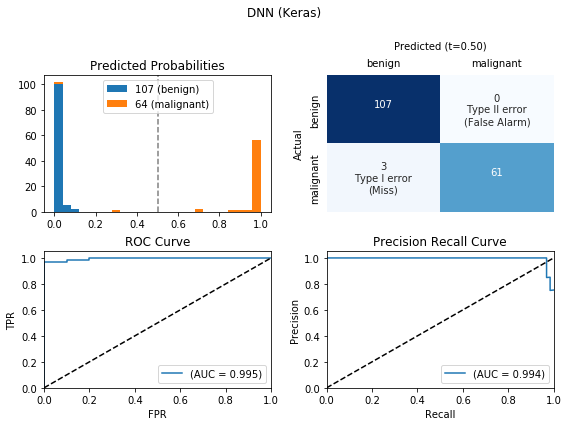

In [10]:
show_results(y_test, y_hat.ravel(), labels, title='DNN (Keras)')